<h1 align="center"></h1>
<h1 align="center">Problem 1 - Building an HBM</h1>
<h2 align="center">Hierarchical Bayesian Modeling of a Truncated Gaussian Population with PyStan and PyJAGS</h2>
<div align="center">Simulating the distribution of "$\boldsymbol{e \cos \omega}$" for hot Jupiter exoplanets from  <i>Kepler</i>. These simulated exoplanet candiates are potentially undergoing migration and orbital circularization. </div> 
<h4 align="center">LSSTC DSFP Session 4, September 21st, 2017</h4>
<h5 align="center">Author: Megan I. Shabram, PhD, 
NASA Postdoctoral Program Fellow,  mshabram@gmail.com</h5>

<div><p>In this Hierachical Bayesian Model workbook, we will begin by using <a href="http://mc-stan.org/users/documentation/case-studies.html">Stan</a>, a <a href="https://en.wikipedia.org/wiki/Hybrid_Monte_Carlo">Hamiltonian Monte Carlo method </a>. Here, PyStan is used to obtain a sample from the full posterior distribution of a truncated Gaussian population model, where the measurement uncertainty of the population constituents are Normally distributed. The truncation renders this HBM with no analytical solution, thus requiring a Monte Carlo numerical approximation technique. After we investigate using Stan, we will then explore the same problem using <a href="https://martynplummer.wordpress.com/2016/01/11/pyjags/"> JAGS</a> a <a href="https://en.wikipedia.org/wiki/Gibbs_sampling">Gibbs sampling</a> method (that reverts to Metropolis-Hastings when necessary). The simulated data sets generated below are modeled after the projected eccentricity obtained for exoplanet systems that both transit and occult their host star (see Shabram et al. 2016)</p><div>

<h3 align="left"> Goals of this series of notebooks:</h3>
- Learn how to use a computing infrastructre that allows you to carry out future HBM research projects. 
- Gain a sense for the workflow involved in setting up an HBM, in particular, using key diagnostics and simulated data.
- Practice data wrangling with pandas data frames and numpy dictionaries. 
- Understand the relationship between data quantity, quality, number of iterations, and analysis model complexity.  The term analysis model is also refered to as a generative model, a population model, or sometimes a shape function. 
- Learn how to run HBM on datasets with missing values using JAGS.<br />
<b>Later:</b>
- Notebook 2: model mispecification and regularization, (running Nm2 data through Nm1 model)
- Notebook 3: Break point model on eclipsing binary data. 

<div>The additional software you will need to install:
    <blockquote>PyJAGS<br />
    PyStan</blockquote>
I have also include two codes in the folder 
<blockquote>triangle_linear.py<br />
credible_interval.py</blockquote></div>

In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
#import pyjags
import pystan
import pickle
import triangle_linear

from IPython.display import display, Math, Latex
from __future__ import division, print_function
from pandas.tools.plotting import *
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
#plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --style monokai


<h3 align="left"> 1. Generate simulated data set from a truncated Gaussian generative model</h3>

<div>Below we designate the population values of our generative model. These are the truths that we should recover if our hiararchical Bayesian model is properly specified and diagnostics have indicated that the simulation has "not-not converged". "You can't 
prove convergence, at best you can fail to prove a failure to converge".</div>


<h4>Set your one-component truncated Gaussian mixture simulated data hyperparameters:</h4>


In [3]:
## In this simulated data set, there are "Ndata" planetary systems (with one planet each)
Ndata = 25 


In [4]:
## Here we asign the dispersion of the simulated population to be 0.3, this is 
## the truth we wish to recover when we run our diagnostics. In other words, this is the 
## spread of projected eccentricities about the mean (In this case the values are symteric 
## about zero, so the mean of the population is zero, and we can treat this paramter as 
## known, simplyfying our model based on our science question!)
sigmae = 0.3 


In [5]:
## We approximate the uncertainty for each measurement as normally distributed about a 
## reported measurement point estimate, or a summary statistics for a posterior estimate.  
sigmahobs = 0.04


<div><p>Eccentricity cannot be greater than 1 physically (or it means an unbound orbit) and that is not the case for planets observed to both transit and occult more than once.
This creates a situation where the distribution for the projected $\boldsymbol{e \cos \omega}$ (h) and $\boldsymbol{e \sin \omega}$ (k) must be truncated between 1 and -1, rendering this problem with no analytical solution, and requaring numerical simulation of the posterior probability.</p> 

<p>In this first notebook, we will ignore $\boldsymbol{e \sin \omega}$, and set up our model using only simulated $\boldsymbol{e \cos \omega}$. This allows us to start with as simple as a model as possible for pedagogical purposes and for workflow.  A workflow that builds in model complexity is approproate for exploratory science, and it this case, it is often helpful for testing for mathematical artifacts that can arrise for your combination of MCMC method and your generative model.  A goal is to find a model that performs well for a variety of possibilies that could be occuring in nature (this is part of our science question).  We will see this unfold in the following notebooks in this series.</p><div> 

In [6]:
## function to draw from truncated normal, this function will be used for both the 
## one- and two-componenet cases in this series of workbooks.  

def rnorm_bound( Ndata, mu, prec, lower_bound = 0.0, upper_bound = float('Inf')):
    x = np.zeros(Ndata)
    if upper_bound <= lower_bound:
        return False
#    for i in range(0, ### Complete ### ): 
    for i in range(0, Ndata ): 
            while True:
                x[i] = np.random.normal(mu,prec,1)
                if( (x[i]>lower_bound) and (x[i]<upper_bound) ): 
                    break
    return x;

<h4>Next we generate our true values and our simulated measurements:</h4>

[ 0.30747183  0.59554793 -0.37221078 -0.28321379 -0.49992654  0.30810652
 -0.14764508 -0.18296005 -0.09565602 -0.01446689 -0.44294712 -0.25944909
  0.40035498  0.10061063 -0.11136807 -0.33554072 -0.13092951 -0.35946689
  0.08262595 -0.22329083  0.19526965 -0.42314127 -0.41593906 -0.12688364
  0.09509567] [ 0.27245028  0.63151043 -0.37031299 -0.2431217  -0.50404995  0.33624442
 -0.095001   -0.20715507 -0.15090493  0.02591808 -0.45642797 -0.31672979
  0.36869073  0.08981001 -0.11954169 -0.38353356 -0.13105833 -0.39040773
  0.11587227 -0.15522461  0.18456136 -0.3977794  -0.43420659 -0.09302731
  0.12919248]


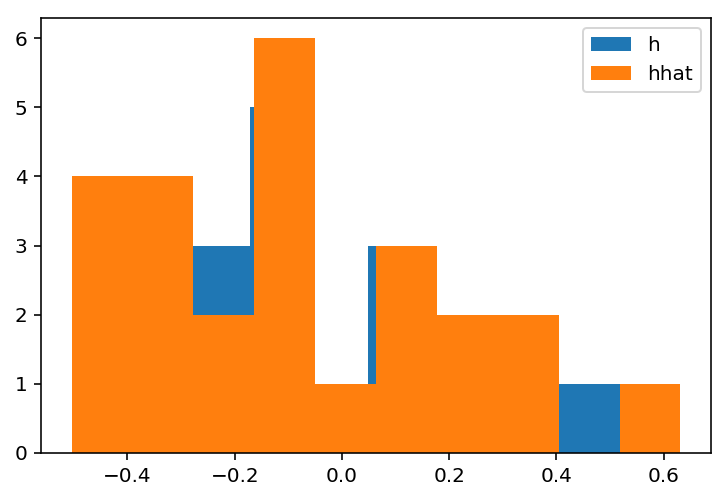

In [8]:
h = np.repeat(0.,Ndata) ## Simuated true values of h = e cos w
hhat = np.repeat(0.,Ndata) ## Simulated measurements of h
hhat_sigma  = np.repeat(sigmahobs,Ndata) ## measurement uncertainty summary statics 

## Note: in this simulated data set, the measurement uncertainties for each projected eccentricity are 
## set to be the same.  You can use the real heteroscadastic uncertainties from your 
## real data set when testing with simulated data in the future. 

for i in range(0,Ndata):
    h[i] = rnorm_bound(1,0,sigmae,lower_bound=-1,upper_bound=1)
    hhat[i] = rnorm_bound(1,h[i],sigmahobs,lower_bound=-1,upper_bound=1)

## Vizualize the true data values, and the simulated measurements:     
print(h, hhat)
plt.hist( h, label='h')
#plt.hist( ##Complete, label='h')
plt.hist(hhat, label='hhat')
#plt.hist( ##Complete, label='hhat')
plt.legend()

<h3 align="left"> 2. Create PyStan truncated Gaussian hierarchical Bayesian model. </h3>

Run the code block below to pre-compile the Stan model. 

In [13]:
eccmodel = """
data {
    int<lower=1> Ndata;
    real<lower=-1,upper=1> hhat[Ndata];
    real<lower=0,upper=1> hhat_sigma[Ndata];
}
parameters {
    real<lower=0> e_sigma;
    real<lower=-1,upper=1> h[Ndata];
}
model {

    e_sigma ~ uniform(0, 1.0);
    
    for (n in 1:Ndata)
      hhat[n] ~ normal(h[n], hhat_sigma[n]);
    
    for (n in 1:Ndata)
      increment_log_prob(normal_log(h[n], 0.0, e_sigma));
}
"""
# Compiled Stan Model
sm = pystan.StanModel(model_code=eccmodel)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_438b4e266a27bc779461f05007a9a701 NOW.


Where in the Stan model above where the truncation is indicated?:




Run the code cell below to carry out the HMC numerical simulation of the Stan model that was compiled above. 

In [14]:
ecc_dat = {'Ndata': len(hhat), 'hhat': hhat, 'hhat_sigma': hhat_sigma}


iters = 10000
fit = sm.sampling(data=ecc_dat, iter=iters, chains=4, seed=48389, refresh=1000, n_jobs=-1)



<h3 align="left"> 3. Perform diagnostics to asses if the model shows signs of having not converged. </h3>

In [20]:
print(fit)

Inference for Stan model: anon_model_438b4e266a27bc779461f05007a9a701.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
e_sigma   0.32  3.4e-4   0.05   0.24   0.29   0.31   0.35   0.43  20000    1.0
h[0]      0.27  2.8e-4   0.04   0.19   0.24   0.27    0.3   0.35  20000    1.0
h[1]      0.62  2.8e-4   0.04   0.54   0.59   0.62   0.65    0.7  20000    1.0
h[2]     -0.36  2.8e-4   0.04  -0.44  -0.39  -0.36  -0.34  -0.29  20000    1.0
h[3]     -0.24  2.8e-4   0.04  -0.32  -0.27  -0.24  -0.21  -0.16  20000    1.0
h[4]      -0.5  2.8e-4   0.04  -0.57  -0.52   -0.5  -0.47  -0.42  20000    1.0
h[5]      0.33  2.8e-4   0.04   0.25    0.3   0.33   0.36   0.41  20000    1.0
h[6]     -0.09  2.8e-4   0.04  -0.17  -0.12  -0.09  -0.07  -0.02  20000    1.0
h[7]      -0.2  2.8e-4   0.04  -0.28  -0.23   -0.2  -0.18  -0.13  20000    1.0
h[8]     -0.15  2.8

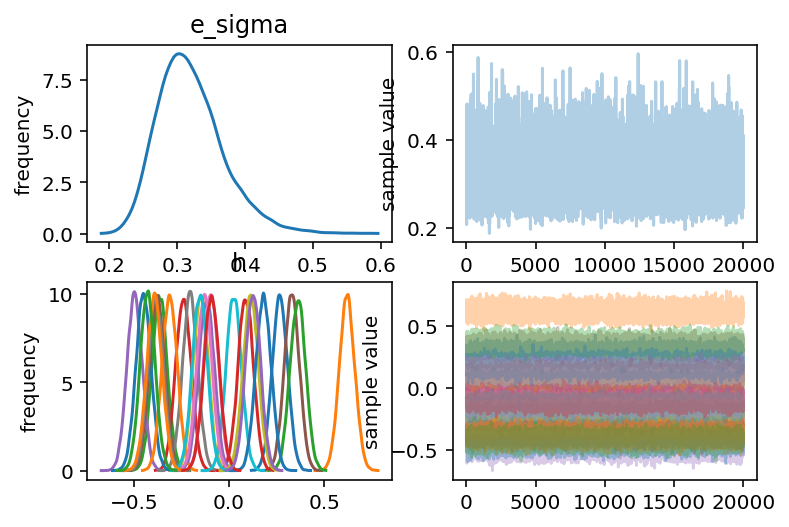

In [21]:
fig = fit.traceplot()

From the diagnostics above, what can you tell about the status of this MCMC numerical simulation?




In [22]:
la = fit.extract(permuted=True)  # returns a dictionary of arrays

a = fit.extract(permuted=False)

e_sigma = la['e_sigma'].reshape(4,-1) # there are 4 chains here, hence the 4, -1
print(e_sigma.shape)
#print(e_sigma.reshape(4,5000))

(4, 5000)


In [ ]:
## Wrangle the dictionary of samples from the posterior:

num_chains = 4

df = pd.DataFrame(la.items())
print(df)

samples_Stan = dict(zip(df[0], df[1].values ))
#print(samples.items())
print(type(samples_Stan['e_sigma']))
print(samples_Stan.items())

#for j, i in samples_Stan.items():
#    print(the keys)
#    print(i.shape)

In [ ]:

## Print and check the shape of the resultant samples dictionary:
#print(samples)
#print(samples.items())
print('-----')
print(samples_Stan['e_sigma'].shape)
print(samples_Stan['h'].shape)
print(samples_Stan['h'][:,3].shape)
print('-----')


## Update the samples dictionary so that it includes keys for the latent variables
## Also, we will use LaTeX formatting to help make legible plots ahead.  
samples_Nm1_Stan = {}

## adjust the thin varible to only look at every #th population element 
thin1 = 1

## Need to enter the number of hyperparameter variables here:
numHyperParams = 1

## Specify the dimension we want for our plot below, for legibility.  
dim1 = (Ndata/thin1) + numHyperParams
print(dim1)

for i in np.arange(0,Ndata,thin1):
    samples_Nm1_Stan.update({'$h_{'+str(i+1)+'}$': samples_Stan['h'][:,i]})

## Add the hyperparameter marginal posterior back in:
samples_Nm1_Stan.update({'$e_{\sigma}$': samples_Stan['e_sigma']})
print(samples_Nm1_Stan['$h_{5}$'].shape)

## Reshape values for diagnostic plot functions (trace, autocorrelation) below:  
samples_Nm1_trace_Stan = {}    
for j, i in samples_Nm1_Stan.items():
    samples_Nm1_trace_Stan.update({str(j): i.reshape(int(len(i)/num_chains),-1)})




<div>  <p>Below is code to look at <b>summary statistics</b> of <b>the marginal posterior distributions</b>  (the probabilistic parameter estimates) 
for the hyperparameter and the latent variables 
(each population constituent), in this case <i>h</i> (a.k.a one term of the projected eccentricity here), of the exoplanet systems we are simulating). </p> </div>

NOTES: [Wikipedia article for credible interval](https://en.wikipedia.org/wiki/Credible_interval)
"Choosing the interval where the probability of being below the interval is as likely as being above it. This interval will include the median. This is sometimes called the equal-tailed interval."

In [ ]:
## equal tailed 95% credible intervals, and posterior distribution means:
def summary(samples, varname, p=95):
    values = samples[varname][0]
    ci = np.percentile(values, [100-p, p])
    print('{:<6} mean = {:>5.1f}, {}% credible interval [{:>4.1f} {:>4.1f}]'.format(
      varname, np.mean(values), p, *ci))

for varname in samples_Nm1_trace_Stan:
    summary(samples_Nm1_trace_Stan, varname)


In [ ]:
## Use pandas three dimensional Panel to represent the trace:
## There is some wait time involved 

trace_1_Stan = pd.Panel({k: v for k, v in samples_Nm1_trace_Stan.items()})
trace_1_Stan.axes[0].name = 'Variable'
trace_1_Stan.axes[1].name = 'Iteration'
trace_1_Stan.axes[2].name = 'Chain'
 
## Point estimates:
print(trace_1_Stan.to_frame().mean())
 
## Bayesian equal-tailed 95% credible intervals:
print(trace_1_Stan.to_frame().quantile([0.05, 0.95]))
  ## ^ entering the values here could be a good question part
    
def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, y=0.95, fontsize='xx-large')
 
    ## Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    ## Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    ## Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
    ## Save figure
    filename = var.replace("\\", "") 
    filename = filename.replace("$", "") 
    filename = filename.replace("}", "") 
    filename = filename.replace("{", "") 
    plt.tight_layout(pad=3)
    #fig.savefig(Nm1_Stan_'+'{}.png'.format(filename))
 
# Display diagnostic plots
for var in trace_1_Stan:
    plot(trace_1_Stan, var)
 


In [ ]:
## Scatter matrix plot:
##    If Ndata is increased, this scatter_matrix might do better to skip every nth latent variable
##    Code for that is in a future code cell, where we make a triangle plot with KDE for 
##    joint 2D marginals. scatter_matrix is a Python Pandas module.

sm = scatter_matrix(trace_1_Stan.to_frame(),  color="#00BFFF", alpha=0.2, figsize=(dim1*2, dim1*2), diagonal='hist',hist_kwds={'bins':25,'histtype':'step', 'edgecolor':'r','linewidth':2})

## y labels size
[plt.setp(item.yaxis.get_label(), 'size', 20) for item in sm.ravel()]

## x labels size 
[plt.setp(item.xaxis.get_label(), 'size', 20) for item in sm.ravel()]

## Change label rotation.  This is helpful for very long labels
#[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]

[s.xaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

## May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]

## Hide all ticks
#[s.set_xticks(()) for s in sm.reshape(-1)]
#[s.set_yticks(()) for s in sm.reshape(-1)]

## Save the figure as .png 
plt.savefig('scatter_matrix_Nm1_Stan.png')


In [ ]:

## Redefine the trace so that we only vizualize every #th latent variable element in 
## the scatter_matrix plot below. Vizualizing all Ndata is too cumbersome for the scatter
## matrix. 

## adjust the thin varible to only look at every #th population element 
##Ndata is 25 use 
thin = 5
##Ndata is 20 use
#thin = 4

## Re-specify the dimension we want for our plot below, with thinning, for legibility.  
dim2 = (Ndata/thin) + numHyperParams
print(dim2)

samples_Nm1_triangle_1_Stan = {}
truths_hhat = {}
truths_h = {}
for i in np.arange(0,Ndata,thin):
    samples_Nm1_triangle_1_Stan.update({'$h_{'+str(i+1)+'}$': samples_Stan['h'][:,i]})
    truths_hhat.update({'$h_{'+str(i+1)+'}$': hhat[i]})
    truths_h.update({'$h_{'+str(i+1)+'}$': h[i]})
samples_Nm1_triangle_1_Stan.update({'$e_{\sigma}$': samples_Stan['e_sigma']})
truths_hhat.update({'$e_{\sigma}$': sigmae})
truths_h.update({'$e_{\sigma}$': sigmae})

## Code below is to reshape values for diagnostic plot functions (trace, autocorrelation, scatter_matrix):  
#samples_Nm1_triangle_trace_Stan = {}    
#for j, i in samples_Nm1_triangle_Stan.items():
#    samples_Nm1_triangle_trace_Stan.update({str(j): i.reshape(int(len(i)/num_chains),-1)})
#
#print(list(samples_Nm1_scatter_matrix_trace.items()))
#print(list(samples_Nm1_scatter_matrix_trace['$h_{6}$'][0]))



In [ ]:
#trace_2.to_frame()
print(samples_Nm1_triangle_1_Stan.keys())
print(5000*num_chains)
print(int(dim2))
print(truths_hhat.values())

In [ ]:

#data = np.asarray(samples_Nm1_scatter_matrix_triangle.values()).reshape((5000*num_chains),int(dim2))
#print(np.asarray(samples_Nm1_scatter_matrix_triangle.values()).reshape((5000*num_chains),int(dim2)).shape)

samples_Nm1_triangle_2_Stan = {}    
for j, i in samples_Nm1_triangle_1_Stan.items():
    samples_Nm1_triangle_2_Stan.update({str(j): i.reshape(-1,1)})
    
data = None
for k, v in samples_Nm1_triangle_2_Stan.items():
    column = v.reshape(-1,1)
    if data is None:
        data = column
    else:
        data = np.hstack((data, column))

print(data.shape)

figure = triangle_linear.corner(data,labels=samples_Nm1_triangle_2_Stan.keys(),labelsy=samples_Nm1_triangle_2_Stan.keys(), truths=truths_h.values(), truths_color = 'black')

#plt.savefig('triangle_linear_Nm1_Stan.png')


Overplot the true value and the measurement uncertainy with the marginal posterior.

In [ ]:
def plot_2(Ndata):
    for i in np.arange(0,Ndata):
        fig = plt.figure(figsize=(8,5))
        x = np.arange(-1,1, 0.001)
        fit = stats.norm.pdf(x, h[i], sigmahobs) 
        plt.plot([hhat[i],hhat[i]], [0,10],label=r'$\hat{h_{'+str(i)+'}}$ (measured)')
        plt.plot([h[i],h[i]], [0,10],label=r'$h_{'+str(i)+'}$ (true value)')
        plt.plot(x,fit,'-',label=r'$N(h_{'+str(i)+'},\sigma_{\hat{h_{'+str(i)+'}}})$')
        plt.hist(samples_Stan['h'][:,i],histtype='step', bins=50, normed=True,label=r'Marginal Posterior of $h_{'+str(i)+'}$')
        plt.xlim(-0.7,0.7)
        plt.ylim(0,13)
        plt.legend()
        plt.text(-.49, 12,'variance of posterior  = '+str(np.var(samples_Stan['h'][:,i])))
        plt.text(-.49, 11.5,'variance of observation = '+str(sigmahobs**2))
        plt.tight_layout(pad=3)
        fig.savefig('Nm1_latent_var_h_Stan'+str(i)+'.png')

plot_2(Ndata)        

Plot draws from the posterior to summarize the population distribution:

In [ ]:
## take some some values of e_sigma from the posterior of e_sigma, at plot the population 
## distribution for these values. These should be normal distributions centered at 0.0 with dispersions that are drawn from e_sigma. 

<h3 align="left"> 4. Complete problems 2 and 3 on the same generative model simulated data set above now using PyJAGS.</h3>

In [ ]:
## JAGS user manual: 
## http://www.uvm.edu/~bbeckage/Teaching/DataAnalysis/Manuals/manual.jags.pdf

## JAGS model code

code = '''

model {
        
    #Population parameters
    e_sigma ~ dunif(0.0, 1.0)
    e_phi <- 1/(e_sigma*e_sigma)
        
    for (n in 1:Ndata){
    
        #True planet properties
        h[n] ~ dnorm(0, e_phi) T(-1,1) #Can try multivariate truncated normal in future
            
        #Observed planet properties
        hhat[n] ~ dnorm(h[n], 1.0/(hhat_sigma[n]*hhat_sigma[n])) T(-1,1)
    }
        
}
'''

How is the truncation specified in the JAGS model above?

In [ ]:
## Load additional JAGS module
pyjags.load_module('glm')
pyjags.load_module('dic')


## See blog post for origination of the adapted analysis tools used here and below:
## https://martynplummer.wordpress.com/2016/01/11/pyjags/

num_chains = 4
iterations = 10000


## data list include only variables in the model
model = pyjags.Model(code, data=dict( Ndata=Ndata, hhat=hhat, 
                                     hhat_sigma=hhat_sigma), 
                     chains=num_chains, adapt=1000)

## Code to speed up compute time. This feature might not be 
## well tested in pyjags at this time. 
## threads=4, chains_per_thread=1 

## 500 warmup / burn-in iterations, not used for inference.
model.sample(500, vars=[])

## Run model for desired steps, monitoring hyperparameter variables, and latent variables
## for hierarchical Bayesian model.
## Returns a dictionary with numpy array for each monitored variable.
## Shapes of returned arrays are (... shape of variable ..., iterations, chains).
## samples = model.sample(#iterations per chain here, vars=['e_sigma', 'h'])
samples_JAGS = model.sample(iterations, vars=['e_sigma', 'h'])

## Code to save, open and use pickled dictionary of samples:
## -- Pickle the data --
#with open('ecc_1_test.pkl', 'wb') as handle:
#   pickle.dump(samples, handle)
## -- Retrieve pickled data --
#with open('ecc_1_test.pkl', 'rb') as handle:
#   retrieved_results = pickle.load(handle)


<div>
  <h4>Data wrangling notes:</h4>
  <p>The pyjags output is a dictionary type (above, this is asigned to the "samples" variable). Here, the keys are <i>e_sigma</i>, <i>h</i>, and <i>k</i> (from the one-component analysis model used above). Furthermore, <br />
<blockquote> e_sigma has shape (1,10000,4), <br /> 
h has shape (25,10000,4), and<br />
</blockquote>
The way to acces the latent variable marginal posteriors before updating the samples dictionary as we do below, you would use: 
<blockquote>
h1 = samples['h'][0,:,:], h2 = samples['h'][1,:,:],  ... hn = samples['h'][n,:,:] and, <br />
</blockquote>
for n population constituents. </p>

  <p>Now, we need to add keys for each latent variable into the dictionary. 
The keys we want here are:<br /> 
<blockquote> e_sigma (the population parameter here), and<br /> 
h1, ..., h25 for the latent variables.<br /> 
</blockquote> </p>

  <p>Our resulting dictionary elements will have the following shapes:
<blockquote> e_sigma will have shape (10000,4)<br /> 
h1 will have shape (10000,4)<br />
.<br />
.<br />
.<br />
h25 will have shape (10000,4)<br />
for a data set with 25 population constituents. </p>
</div>

In [ ]:
#print(samples)
#print(samples.items())

## Print and check the shape of the resultant samples dictionary:
print(samples_JAGS['e_sigma'].shape)
print(samples_JAGS['e_sigma'].squeeze(0).shape)
print(samples_JAGS['h'].shape)
print(samples_JAGS['h'][0,:,:].shape)
print('-----')


## Update the samples dictionary so that it includes keys for the latent variables
## Also, we will use LaTeX formatting to help make legible plots ahead.  
samples_Nm1_JAGS = {}

## adjust the thin varible to only look at every 10th population element by setting it to 10
thin = 1
## Need to enter the number of hyperparameter variables here:
numHyperParams = 1
## Specify the dimension we want for our plot below, for legibility.  
dim = (Ndata/thin)*2 + numHyperParams
print(dim)

for i in np.arange(0,Ndata,thin):
    #samples_Nm1({hval: samples['h'][i,:,:]})
    samples_Nm1_JAGS.update({'$h_{'+str(i)+'}$': samples_JAGS['h'][i,:,:]})
#print(samples_2['h11'].shape)

## Add the hyperparameter marginal posterior back in:
samples_Nm1_JAGS.update({'$e_{\sigma}$': samples_JAGS['e_sigma'].squeeze(0)})

## Below, examine the updated and reformatted sample dictionary to include keys for 
## latent variables 
for j, i in samples_Nm1_JAGS.items():
    print(j)
    print(i)
samples_Nm1_JAGS['$h_{5}$'][0]

<div>  <p>Below is code to look at <b>summary statistics</b> of <b>the marginal posterior distributions</b>  (the probabilistic parameter estimates) 
for the hyperparameter and the latent variables 
(each population constituent), in this case <i>h</i> and <i>k</i> (a.k.a projected eccentricity here), of the exoplanet systems we are simulating). </p> </div>

In [ ]:
## equal tailed 95% credible intervals, and posterior distribution means:
def summary(samples_JAGS, varname, p=95):
    values = samples_JAGS[varname][0]
    ci = np.percentile(values, [100-p, p])
    print('{:<6} mean = {:>5.1f}, {}% credible interval [{:>4.1f} {:>4.1f}]'.format(
      varname, np.mean(values), p, *ci))

for varname in samples_Nm1_JAGS:
    summary(samples_Nm1_JAGS, varname)


In [ ]:
## Use pandas three dimensional Panel to represent the trace:

trace = pd.Panel({k: v for k, v in samples_Nm1_JAGS.items()})
trace.axes[0].name = 'Variable'
trace.axes[1].name = 'Iteration'
trace.axes[2].name = 'Chain'
 
## Point estimates:
print(trace.to_frame().mean())
 
## Bayesian equal-tailed 95% credible intervals:
print(trace.to_frame().quantile([0.05, 0.95]))
  ## ^ entering the values here could be a good question part
    
def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, y=0.95, fontsize='xx-large')
 
    ## Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    ## Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    ## Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
    ## Save figure
    filename = var.replace("\\", "") 
    filename = filename.replace("$", "") 
    filename = filename.replace("}", "") 
    filename = filename.replace("{", "") 
    plt.tight_layout(pad=3)
    fig.savefig('Nm1_JAGS_'+'{}.png'.format(filename))
 
# Display diagnostic plots
for var in trace:
    plot(trace, var)
 


In [ ]:
## Scatter matrix plot:

## Redefine the trace so that we only vizualize every 10th latent variable element in 
## the scatter_matrix plot below. Vizualizing all 50 is too cumbersome for the scatter
## matrix. 

samples_Nm1_for_scatter_matrix = {}
start = int(iters-1000)

## adjust the thin varible to only look at every 10th population element by setting it to 10
thin = 1
numHyperParams = 1
dim = (Ndata/thin)*2 + numHyperParams
print(dim)

for i in np.arange(0,Ndata,thin):
    samples_Nm1_for_scatter_matrix.update({'$h_{'+str(i+1)+'}$': samples_JAGS['h'][i,start::,:]})
samples_Nm1_for_scatter_matrix.update({'$e_{\sigma}$': samples_JAGS['e_sigma'].squeeze(0)})

for j, i in samples_Nm1_for_scatter_matrix.items():
    print(j)
#    print(i)

trace_2 = pd.Panel({k: v for k, v in samples_Nm1_for_scatter_matrix.items()})

sm = scatter_matrix(trace_2.to_frame(),  color="darkturquoise", alpha=0.2, figsize=(dim*2, dim*2), diagonal='hist',hist_kwds={'bins':25,'histtype':'step', 'edgecolor':'r','linewidth':2})
## y labels size
[plt.setp(item.yaxis.get_label(), 'size', 20) for item in sm.ravel()]
## x labels size 
[plt.setp(item.xaxis.get_label(), 'size', 20) for item in sm.ravel()]
## Change label rotation
## This is helpful for very long labels
#[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.xaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
## May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]
## Hide all ticks
#[s.set_xticks(()) for s in sm.reshape(-1)]
#[s.set_yticks(()) for s in sm.reshape(-1)]

plt.savefig('scatter_matrix_Nm1_JAGS.png')


In [ ]:

## Redefine the trace so that we only vizualize every #th latent variable element in 
## the scatter_matrix plot below. Vizualizing all Ndata is too cumbersome for the scatter
## matrix. 

## adjust the thin varible to only look at every #th population element 
##Ndata is 25 use 
thin = 5
##Ndata is 20 use
#thin = 4

## Re-specify the dimension we want for our plot below, with thinning, for legibility.  
dim2 = (Ndata/thin) + numHyperParams
print(dim2)

samples_Nm1_triangle_1_JAGS = {}
truths_hhat = {}
truths_h = {}
for i in np.arange(0,Ndata,thin):
    samples_Nm1_triangle_1_JAGS.update({'$h_{'+str(i+1)+'}$': samples_JAGS['h'][:,i]})
    truths_hhat.update({'$h_{'+str(i+1)+'}$': hhat[i]})
    truths_h.update({'$h_{'+str(i+1)+'}$': h[i]})
samples_Nm1_triangle_1_JAGS.update({'$e_{\sigma}$': samples_JAGS['e_sigma']})
truths_hhat.update({'$e_{\sigma}$': sigmae})
truths_h.update({'$e_{\sigma}$': sigmae})

## Reshape values for diagnostic plot functions (trace, autocorrelation, scatter_matrix):  
#samples_Nm1_triangle_trace_Stan = {}    
#for j, i in samples_Nm1_triangle_Stan.items():
#    samples_Nm1_triangle_trace_Stan.update({str(j): i.reshape(int(len(i)/num_chains),-1)})
#
#print(list(samples_Nm1_scatter_matrix_trace.items()))
#print(list(samples_Nm1_scatter_matrix_trace['$h_{6}$'][0]))



In [ ]:

#data = np.asarray(samples_Nm1_scatter_matrix_triangle.values()).reshape((5000*num_chains),int(dim2))
#print(np.asarray(samples_Nm1_scatter_matrix_triangle.values()).reshape((5000*num_chains),int(dim2)).shape)

samples_Nm1_triangle_2_Stan = {}    
for j, i in samples_Nm1_triangle_1_Stan.items():
    samples_Nm1_triangle_2_Stan.update({str(j): i.reshape(-1,1)})
    
data = None
for k, v in samples_Nm1_triangle_2_Stan.items():
    column = v.reshape(-1,1)
    if data is None:
        data = column
    else:
        data = np.hstack((data, column))

print(data.shape)

figure = triangle_linear.corner(data,labels=samples_Nm1_triangle_2_Stan.keys(),labelsy=samples_Nm1_triangle_2_Stan.keys(), truths=truths_h.values(), truths_color = 'black')

plt.savefig('triangle_linear_Nm1_JAGS.png')


In [ ]:
def plot_2(Ndata):
    for i in np.arange(0,Ndata):
        fig = plt.figure(figsize=(8,5))
        x = np.arange(-1,1, 0.001)
        fit = stats.norm.pdf(x, h[i], sigmahobs) 
        plt.plot([hhat[i],hhat[i]], [0,10],label=r'$\hat{h_{'+str(i)+'}}$ (measured)')
        plt.plot([h[i],h[i]], [0,10],label=r'$h_{'+str(i)+'}$ (true value)')
        plt.plot(x,fit,'-',label=r'$N(h_{'+str(i)+'},\sigma_{\hat{h_{'+str(i)+'}}})$')
        plt.hist(samples_Stan['h'][:,i],histtype='step', bins=50, normed=True,label=r'Marginal Posterior of $h_{'+str(i)+'}$')
        plt.xlim(-0.7,0.7)
        plt.ylim(0,13)
        plt.legend()
        plt.text(-.49, 12,'variance of posterior  = '+str(np.var(samples_Stan['h'][:,i])))
        plt.text(-.49, 11.5,'variance of observation = '+str(sigmahobs**2))
        plt.tight_layout(pad=3)
        fig.savefig('Nm1_latent_var_h_JAGS'+str(i)+'.png')

plot_2(Ndata)        

<h3 align="left"> 5. Exploring the size of your dataset (Ndata) and the precision of your measurements </h3> Go to the beginning of the notebook and adjust Ndata so that it is much smaller, say around 5 or 10 and rerun your notebooks (be sure to add an extension to your diagnostic plot filenames)

Now adjust the precision (sigmahobs) to a much smaller number (say 0.001), and re-run your notebooks. 

<h3 align="left">Challenge Problem: Missing data </h3>



Using JAGS, you can experiment with a situation where you may have some missing data. to incorporate missing data, you can insert an 'NA' in your input data. This is possible in a hierarchical model because for each iteration in the MCMC routine, a value can be drawn from the population distribution.  The challenge problem here is to data wrangle your input data for hhat, replacing a percentage of the values with 'NA'. After you have your new hhat array, you can read it into your PyJAGS infrastructure above and investigate.